In [1]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt # 基础数据处理

from random import sample # 随机采样

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader # Pytorch
print(torch.__version__)

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm as tqdm

train_root = './train'
labels = os.listdir(train_root)


class DrawDataset(Dataset):
    def __init__(self, data_root = '',transform = None,anlysis = False):
        self.mean = 0.16443629118313927
        self.std = 0.3239202530511322
        self.transform = transform
        self.anlysis = False # only used when first computation
        self.label_mapper = {'airplane': 0, 'ant': 1, 'bear': 2, 'bird': 3, 'bridge': 4,
                        'bus'     : 5, 'calendar': 6, 'car': 7, 'chair': 8, 'dog': 9,
                        'dolphin' : 10, 'door': 11, 'flower': 12, 'fork': 13, 'truck': 14}
        self.IO_mapper = []
        for x in self.label_mapper:
            print('loading class:',x)
            temp_root = os.path.join(train_root,x)
            temp_list = os.listdir(temp_root)
            for img in temp_list:
                full_str = os.path.join(temp_root,img)
                self.IO_mapper.append([full_str , self.label_mapper[x]])
        print('Data loading finished,',len(self.IO_mapper),'totally')
        if anlysis:
            self.analysis()
    
    def __len__(self):
        return len(self.IO_mapper)
    
    def __getitem__(self,idx):
        image = cv2.imread(self.IO_mapper[idx][0],0)
        if self.transform is not None:
            image = self.transform(Image.fromarray(image))
        return image,self.IO_mapper[idx][1]
    
    def analysis(self):
        print('Data analysising……')
        self.mean = 0
        self.std = 0
        temp = []
        for i in tqdm(self):
            img = i[0].flatten() # 转为一维数组方便计算
            self.mean += np.sum(img)
        self.mean = self.mean / (len(self)*img.size)
        print('Mean:',self.mean)
        for i in self:
            img = i[0].flatten() # 转为一维数组方便计算
            self.std = self.std + np.sum((img - self.mean) ** 2)
        self.std = np.sqrt(self.std / (len(self)*img.size))
        print('Std:',self.std)


# Preprocessing
train_transform = transforms.Compose([
    transforms.RandomCrop(28,padding = 4), # 在周围补0后随机裁切，相当于平移这个图像
#     transforms.Resize(32),
    transforms.RandomHorizontalFlip(), # 一半的概率水平翻转
    transforms.RandomRotation((-30,30)), # 随机旋转
    transforms.ToTensor(),
    transforms.Normalize((0.16443629118313927, ),(0.3239202530511322, ))
])

# Dataset & Dataloader
Draws = DrawDataset('./train',transform = None)
dl = DataLoader(Draws, batch_size = 4, shuffle = True, num_workers = 8)


def imshow(img):
    img = img/2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

dataiter = iter(dl)
images,labels = dataiter.next()

k = list(Draws.label_mapper.keys()) # [1,2,3,5,4]
v = list(Draws.label_mapper.values()) #[3,5,2,1,1]
imshow(torchvision.utils.make_grid(images))

labelshow = ''
for i in labels:
    labelshow += k[v.index(i)] + ' '
print(labelshow)

1.1.0
loading class: airplane
loading class: ant
loading class: bear
loading class: bird
loading class: bridge
loading class: bus
loading class: calendar
loading class: car
loading class: chair
loading class: dog
loading class: dolphin
loading class: door
loading class: flower
loading class: fork
loading class: truck
Data loading finished, 6000 totally
airplane calendar bear bridge 


In [2]:
RANDOM_SEED = 1
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 400*15
NUM_EPOCHS = 250

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 15

# Other
GRAYSCALE = True

# for server-1
# Datasets
trainset = Draws

# DataLoader

trainloader = DataLoader(Draws, batch_size=BATCH_SIZE, shuffle = True, num_workers = 8)

classes = ['airplane', 'ant', 'bear', 'bird', 'bridge',
                        'bus', 'calendar', 'car', 'chair', 'dog',
                        'dolphin', 'door', 'flower', 'fork', 'truck']

# Checking datasets
for images, labels in trainloader:
    X_all = images.numpy().reshape(6000,784)
    print('Image batch dimensions:', X_all.shape)
    Y_all = labels.numpy()
    print('Image label dimensions:', Y_all.shape)
    break



Image batch dimensions: (6000, 784)
Image label dimensions: (6000,)


In [3]:
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split

from skimage.io import imread
from skimage.transform import resize

# Split DATA

In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X_all, Y_all, test_size=0.25,random_state=12450)
print('Image batch dimensions', X_train.shape)

Image batch dimensions (4500, 784)


# Train data with parameter optimization


In [5]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]
svc = svm.SVC()
clf = GridSearchCV(svc, param_grid)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Classification report for - \n{}:\n{}\n".format(
    clf, metrics.classification_report(y_test, y_pred)))

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Classification report for - 
GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0):
              precision    recall  f1-score   support

           0       0.41      0.51      0.45        99
           1       0.34      0.31      0.32        99
           2       0.46      0.39     

# ZIMO

In [90]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC,SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
'''train_data = sys.argv[1]
test_data = sys.argv[2]
#load data
data = pd.read_csv(train_data)

X = data.iloc[:,1:4097]
#print(X.columns)
Y = data.loc[:,'categories']
'''

#99.81 10 fold C 2.0 rbf
#############   cv  ###################################
# number = 20

# mi = [-4 + i*8.0/(number-1) for i in range(number) ]

# #Cs = [10**i for i in mi]
# Cs = [0.5,0.8,1.4,2,3,4]
# parameters = { 'C':Cs}
# svc = SVC(gamma="scale",kernel = 'rbf',random_state =2)
# clf = GridSearchCV(svc, parameters,cv = 5,n_jobs =-1,return_train_score = True)
# clf.fit(x_train, y_train)



# y_train_pred = clf.predict(x_train)
# #y_valid_pred = clf.predict(x_valid_scaled)

# train_accuracy = accuracy_score(y_train, y_train_pred)

# #test_accuracy = accuracy_score(y_valid,y_valid_pred)

# joblib.dump(clf, "SVC_CV4.model")

# print('SVM')
# print('Training accuracy: %0.2f%%' % (train_accuracy*100))
##########################################################################
for images, labels in trainloader:
    X_all = images.numpy().reshape(6000,784)
    print('Image batch dimensions:', tensorarray.shape)
    Y_all = labels.numpy()
    print('Image label dimensions:', labels.shape)
    break

# estimator = PCA(n_components=50)
# X_all = estimator.fit_transform(X_all)

x_train, x_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=12450)
clf = SVC(C=5, gamma = "scale",kernel = 'poly', probability=True, random_state = 12450).fit(x_train, y_train)
# clf = LinearSVC(C=1.623776739188721, random_state =None).fit(x_train, y_train)

y_result=clf.predict(x_test)
y_train_result=clf.predict(x_train)

test_accuracy = accuracy_score(y_test,y_result)
test_accuracy2 = accuracy_score(y_train,y_train_result)
print(test_accuracy)
print(test_accuracy2)

Image batch dimensions: (6000, 784)
Image label dimensions: torch.Size([6000])
0.7216666666666667
0.9989583333333333


[ 8  5  3 ... 12 14 13]
[ 8  5  9 ... 13 14 13]


In [6]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import time
a = time.time()
trainloader = DataLoader(Draws, batch_size=6000, shuffle = True, num_workers = 8)

for images, labels in trainloader:
    X_all = images.numpy().reshape(6000,784)
    print('Image batch dimensions:', X_all.shape)
    Y_all = labels.numpy()
    print('Image label dimensions:', Y_all.shape)
    break

# estimator = PCA(n_components=50)
# X_all = estimator.fit_transform(X_all)
estimator = PCA(n_components=50)
X_all = estimator.fit_transform(X_all)

x_train, x_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state=12450)

classifiers = [
    KNeighborsClassifier(3),
    SVC(C=5, gamma = "scale",kernel = 'poly', probability=True, random_state = 12450),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__

    print("="*30)
    print(name)

    print('****Results****')
    train_predictions = clf.predict(x_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))

    train_predictions = clf.predict_proba(x_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))

    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)

print("="*30)
print('time',time.time()-a)


Image batch dimensions: (6000, 784)
Image label dimensions: (6000,)
KNeighborsClassifier
****Results****
Accuracy: 65.5833%
Log Loss: 5.876861158177713
SVC
****Results****
Accuracy: 72.9167%
Log Loss: 0.8115342989166218


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


NuSVC
****Results****
Accuracy: 4.7500%
Log Loss: 2.7109431714854395
DecisionTreeClassifier
****Results****
Accuracy: 46.8333%
Log Loss: 18.363116116627527


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier
****Results****
Accuracy: 54.5000%
Log Loss: 4.267723733085799
AdaBoostClassifier
****Results****
Accuracy: 18.6667%
Log Loss: 2.528975301369996
GradientBoostingClassifier
****Results****
Accuracy: 62.7500%
Log Loss: 1.1322976528596052
GaussianNB
****Results****
Accuracy: 60.4167%
Log Loss: 1.5090067047982545
LinearDiscriminantAnalysis
****Results****
Accuracy: 57.9167%
Log Loss: 1.477031041924749
QuadraticDiscriminantAnalysis
****Results****
Accuracy: 67.2500%
Log Loss: 3.169053410025206
time 161.2922716140747


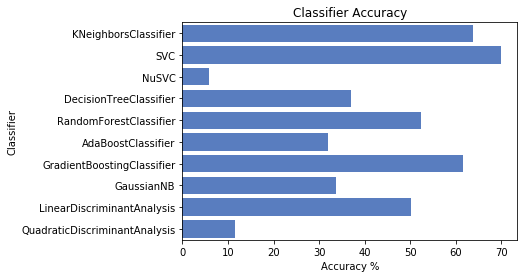

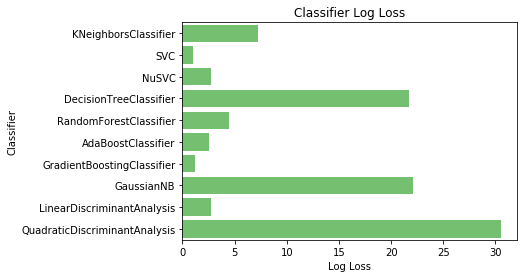

In [11]:
import seaborn as sns
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

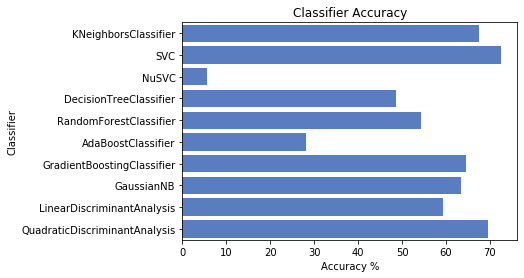

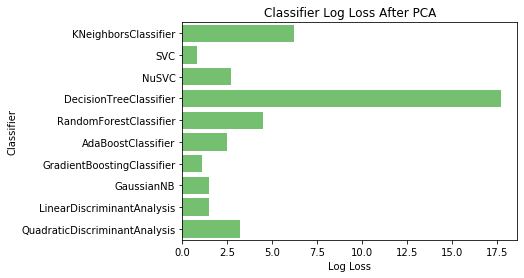

In [14]:
import seaborn as sns
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss After PCA')
plt.show()

In [1]:
0.01-1e-2

0.0